In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import gensim
from gensim.models import KeyedVectors
from IPython.display import clear_output
from collections import Counter
from tqdm import tqdm
import seaborn as sns
import nltk
import json

%matplotlib inline

In [2]:
from pymystem3 import Mystem
from string import punctuation

In [3]:
def read_queries_with_lemmatization(path):
    f = open(path)
    queries = []
    tags = []
    mystem = Mystem()
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        tmp_ = []
        text = tokenizer.tokenize(line.lower())
        text_tagged = nltk.pos_tag(text, lang='rus')
        
        for i, q in enumerate(text):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                q_ = mystem.lemmatize(q)
                tmp.append("".join(q_).split()[0])
                tmp_.append(text_tagged[i][1])
        queries.append(tmp)
        tags.append(tmp_)
    f.close()
    return (queries, tags)

In [4]:
path = 'data/requests.uniq.train'
train_lem = read_queries_with_lemmatization(path)
path = 'data/requests.uniq.test'
test_lem = read_queries_with_lemmatization(path)
train_lem[0][:5], train_lem[1][:5], test_lem[0][:5], test_lem[1][:5], len(train_lem[0]), len(test_lem[0])

([['сибирский', 'сеть', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карта', 'россия'],
  ['ноофен', 'для', 'какой', 'болезнь'],
  ['маус', 'хаус', 'спб']],
 [['A=pl', 'S', 'A=m', 'S', 'S'],
  ['NUM=ciph', 'V', 'S', 'NUM=ciph'],
  ['S', 'S', 'PR', 'S', 'S'],
  ['V', 'PR', 'A-PRO=pl', 'A=f'],
  ['NONLEX', 'NONLEX', 'NONLEX']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикий', 'вишня'],
  ['тася', 'кривун', 'танец', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 [['V', 'PR', 'S', 'S'],
  ['S', 'A=f', 'S'],
  ['S', 'S', 'S', 'PR', 'S'],
  ['V', 'S'],
  ['NONLEX', 'NONLEX', 'NONLEX']],
 51353,
 21174)

In [37]:
count_words = Counter()

for d in [train_lem[0]]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.12185658, 0.16966756, 0.20326518, 0.23018925, 0.2515358 ,
        0.27062838, 0.28792218, 0.30358516, 0.31885922, 0.32964299]))

In [6]:
tmp = np.unique(np.hstack(train_lem[1]))
tmp1 = np.unique(np.hstack(test_lem[1]))
tmp = np.hstack([tmp, tmp1])
tmp = np.unique(tmp)
tmp, len(tmp)

(array(['A', 'A-PRO', 'A-PRO=f', 'A-PRO=m', 'A-PRO=n', 'A-PRO=pl',
        'A-PRO=sg', 'A=brev', 'A=comp', 'A=comp2', 'A=f', 'A=m', 'A=n',
        'A=pl', 'A=sg', 'ADV', 'ADV-PRO', 'ADV-PRO=abbr', 'ADV-PRO=comp',
        'ADV-PRO=distort', 'ADV=abbr', 'ADV=comp', 'ADV=comp2',
        'ANUM=ciph', 'ANUM=f', 'ANUM=m', 'ANUM=n', 'ANUM=pl', 'ANUM=sg',
        'CONJ', 'INIT=abbr', 'INTJ', 'INTJ=distort', 'NONLEX',
        'NONLEX=abbr', 'NUM', 'NUM=acc', 'NUM=ciph', 'NUM=comp', 'NUM=dat',
        'NUM=f', 'NUM=gen', 'NUM=ins', 'NUM=loc', 'NUM=m', 'NUM=n',
        'NUM=nom', 'PARENTH', 'PART', 'PR', 'PRAEDIC', 'PRAEDIC-PRO',
        'PRAEDIC=comp', 'S', 'S-PRO', 'S-PRO=acc', 'S-PRO=dat',
        'S-PRO=gen', 'S-PRO=ins', 'S-PRO=loc', 'S-PRO=n=sg', 'S-PRO=pl',
        'S=m', 'V'], dtype='<U32'), 64)

In [7]:
tags = tmp
tags_to_ind = {}
ind = 0
for t in tags:
    tags_to_ind[t] = ind
    ind += 1

## Сетки

* Просто добавляем тег как фичу

In [8]:
emb_2 = KeyedVectors.load_word2vec_format("ft_native_300_ru_wiki_lenta_lower_case.vec")

In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
def calculate_n_tokens(emb):
    n_tokens = 0
    for word in count_words.keys():
        if word in emb.vocab and count_words[word] >= 3:
            n_tokens += 1
    return n_tokens + 1

In [11]:
def transform_to_features(emb, emb_size, ind_to_word, batch_x, batch_x_tags):
    to_emb = np.zeros((len(batch_x), len(batch_x[0])+1, emb_size + len(tags)))
    for i in range(len(batch_x)):
        to_emb[i][0] = np.ones(emb_size + len(tags))
        for j in range(len(batch_x[i])):
            if batch_x[i][j] != pad_id:
                to_emb[i][j+1][:emb_size] = emb[ind_to_word[batch_x[i][j]]]
                if batch_x_tags[i][j] >= 0:
                    to_emb[i][j+1][emb_size + batch_x_tags[i][j]] = 1
    return to_emb

In [12]:
class Net(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens) 
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)
        logits = self.logits(lstm_out[0])
        
        return logits

In [13]:
pad = '#PAD#'
pad_id = 0

def construct_vocab(emb, count_words):
    word_to_ind = dict()
    word_to_ind['#PAD#'] = 0
    ind_to_word = ['#PAD#', ]
    
    count = 1
    for word in count_words.keys():
        if count_words[word] >= 3 and word in emb.vocab:
            ind_to_word.append(word)
            word_to_ind[word] = count
            count += 1
    return ind_to_word, word_to_ind


def as_matrix(sequences, tags, word_to_ind, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((2, len(sequences), max_len), dtype=int)
    for i, seq in enumerate(sequences):
        for j, word in enumerate(seq[:max_len]):
            if word in word_to_ind.keys():
                matrix[0][i][j] = word_to_ind[word]
                matrix[1][i][j] = tags_to_ind[tags[i][j]]
            else:
                matrix[0][i][j] = pad_id
                matrix[1][i][j] = -1
        for j in range(max_len, len(seq)):
            matrix[0][i][j] = pad_id
            matrix[1][i][j] = -1
    
    return matrix

In [14]:
def compute_loss(network, batch):
    """
    use scalar crossentropy loss (neg llh) loss 
    """
    batch_x = batch[0]
    batch_tags = batch[1]
    batch_x = np.array(batch_x)
    batch_tags = np.array(batch_tags)

    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    batch_tags_inp = batch_tags[:, :-1]
    batch_tags_next = batch_tags[:, 1:]
    
    logits_for_next = network.forward(batch_x_inp, batch_tags_inp)
    logits_for_next = logits_for_next[:, 1:]
    
    answers = torch.argmax(logits_for_next, dim=-1).numpy()
    logits_for_next = logits_for_next.contiguous()
    logits_for_next = logits_for_next.view(-1, logits_for_next.shape[-1])
    
    accr = np.array([answers == batch_x_next]) * np.array([answers != pad_id])
    accr = accr.sum()
    to_div = np.sum(np.array([batch_x_next != pad_id]))
    batch_x_next = torch.tensor(batch_x_next, dtype=torch.int64)
    batch_x_next = batch_x_next.view(-1)
    
    loss = F.cross_entropy(logits_for_next, batch_x_next, ignore_index=pad_id, reduction='mean')
    
    
    return loss, accr, to_div

In [15]:
from random import choice

def generate_batch(train, batch_size, word_to_ind, max_len=None):
    random_x = np.random.randint(0, len(train[0]), size=batch_size)
    batch_x = []
    batch_tags = []
    for x in random_x:
        batch_x.append(train[0][x])
        batch_tags.append(train[1][x])
    return as_matrix(batch_x, batch_tags, word_to_ind, max_len)

In [16]:
batch_size = 64 
n_epochs = 20 
n_batches_per_epoch = 400  
n_validation_batches = 160

In [85]:
from torch.optim import Adam
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = Net(emb_2, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    to_div = 0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t, to_div_t = compute_loss(network, generate_batch(train_lem, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        to_div += to_div_t
        
    train_loss_ /= n_batches_per_epoch
    #train_accr_ /= n_batches_per_epoch
    train_accr_ /= to_div
    
    val_loss_=0
    val_accr_=0
    to_div = 0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t, to_div_t = compute_loss(network, generate_batch(test_lem, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
        to_div += to_div_t
        
    val_loss_ /= n_validation_batches
    #val_accr_ /= n_validation_batches
    val_accr_ /= to_div
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.415038217306137, val loss: 7.029473960399628

Epoch: 0, train accr: 0.06012615392945126, val accr: 0.08210409128861676


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 6.588179706335068, val loss: 6.555705967545509

Epoch: 1, train accr: 0.10989722424536699, val accr: 0.10720432751413818


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.104913908243179, val loss: 6.365627136826515

Epoch: 2, train accr: 0.13640310414066315, val accr: 0.12206235872412184


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 5.751491576433182, val loss: 6.201145070791244

Epoch: 3, train accr: 0.1518869828456105, val accr: 0.12976097595574154


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 5.463841874599456, val loss: 6.125228527188301

Epoch: 4, train accr: 0.165665875974246, val accr: 0.13747347980869504


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.223688576221466, val loss: 6.060811606049538

Epoch: 5, train accr: 0.18190424668650257, val accr: 0.1438562857244293


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 5.02456667304039, val loss: 6.020030668377876

Epoch: 6, train accr: 0.1990015235607792, val accr: 0.1467916159954217


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.8251614201068875, val loss: 5.995430633425713

Epoch: 7, train accr: 0.2121998000918497, val accr: 0.15825107793179632


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.649763660430908, val loss: 5.9933482021093365

Epoch: 8, train accr: 0.22680231774693438, val accr: 0.1587067299244421


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.489338699579239, val loss: 6.045060223340988

Epoch: 9, train accr: 0.24403225806451612, val accr: 0.15648024700021052


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.325403891801834, val loss: 6.019878289103508

Epoch: 10, train accr: 0.26187012844439567, val accr: 0.16132177681473456


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.19681582570076, val loss: 6.081585231423378

Epoch: 11, train accr: 0.27377579927155, val accr: 0.15985796653072704


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.03578318297863, val loss: 6.066061696410179

Epoch: 12, train accr: 0.29419314742758323, val accr: 0.160538179768949


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.9093258064985275, val loss: 6.077114847302437

Epoch: 13, train accr: 0.3083000203265804, val accr: 0.1633900956308436


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.779133513569832, val loss: 6.045979431271553

Epoch: 14, train accr: 0.32664359861591696, val accr: 0.16685357818742552


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.6739465874433517, val loss: 6.1165186882019045

Epoch: 15, train accr: 0.33969682230869, val accr: 0.16361121946030283


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.5566707360744476, val loss: 6.144429913163185

Epoch: 16, train accr: 0.3544253050206465, val accr: 0.16442361894024804


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.459779422879219, val loss: 6.2179121434688565

Epoch: 17, train accr: 0.3693340342080789, val accr: 0.16126997476871321


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.383422926068306, val loss: 6.212906065583229

Epoch: 18, train accr: 0.38028302014056575, val accr: 0.16483516483516483


100%|██████████| 400/400 [02:51<00:00,  2.35it/s]



Epoch: 19, train loss: 3.2591949808597565, val loss: 6.271716690063476

Epoch: 19, train accr: 0.3971612212104981, val accr: 0.15462953340953964
Finished!


In [86]:
torch.save(network.state_dict(), 'add_pos_tagging_as_feature.pwf')

In [17]:
ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = Net(emb_2, ind_to_word)
network.load_state_dict(torch.load('add_pos_tagging_as_feature.pwf'))

In [18]:
def compute_accr(network, batch):
    batch_x = batch[0]
    batch_tag = batch[1]
    
    batch_x = np.array(batch_x)
    batch_tag = np.array(batch_tag)
    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    batch_tag_inp = batch_tag[:, :-1]
    batch_tag_next = batch_tag[:, 1:]
    
    logits_for_next = network.forward(batch_x_inp, batch_tag_inp)
    logits_for_next = logits_for_next[:, 1:]
    
    answers = torch.argmax(logits_for_next, dim=-1).numpy()
    
    accr = np.array([answers == batch_x_next]) * np.array([answers != pad_id])
    accr = accr[0]
    accr = accr.sum(axis=0)
    to_divide = np.array([batch_x_next != pad_id])[0].sum(axis=0)
    
    return accr, to_divide

def get_batch(data, left, right, batch_size, word_to_ind, max_len=None):
    slice_x = np.arange(left, right, 1)
    batch_x = []
    batch_tag = []
    for x in slice_x:
        batch_x.append(data[0][x])
        batch_tag.append(data[1][x])
    return as_matrix(batch_x, batch_tag, word_to_ind, max_len)

def try_lengthes(data):
    accr = np.zeros(np.max(list(map(len, data[0]))))
    to_div = np.zeros(np.max(list(map(len, data[0]))))
    
    for _ in tqdm_notebook(range(0, len(data[0])-batch_size, batch_size)):
        accr_t, div_t = compute_accr(network, get_batch(data, _, _+batch_size, batch_size, word_to_ind))
        accr[:len(accr_t)] += accr_t
        to_div[:len(div_t)] += div_t
    eps = 1
    return accr / (to_div + eps), accr.sum() / to_div.sum()

In [19]:
def approximate_pad(data):
    to_pad = 0
    all_ = 0
    for x in data:
        for word in x:
            all_ += 1
            if word not in word_to_ind.keys():
                to_pad += 1
    return to_pad / all_

In [99]:
from tqdm import tqdm_notebook

on_train, all_accr = try_lengthes(train_lem)
on_train[:10], all_accr

(array([0.22534229, 0.3419334 , 0.46927353, 0.51727253, 0.55219961,
        0.5572743 , 0.57848837, 0.58447489, 0.56936226, 0.54239257]),
 0.4007140359841863)

In [100]:
on_test, all_accr = try_lengthes(test_lem)
on_test[:10], all_accr

(array([0.13774834, 0.14425538, 0.16985902, 0.1910342 , 0.18946509,
        0.19265442, 0.19807281, 0.18886861, 0.16057234, 0.11239193]),
 0.1608981155306269)

In [21]:
from tqdm import tqdm_notebook

on_test, all_accr = try_lengthes(test_lem)
on_test[:10], all_accr

(array([0.13774834, 0.14425538, 0.16985902, 0.1910342 , 0.18946509,
        0.19265442, 0.19807281, 0.18886861, 0.16057234, 0.11239193]),
 0.1608981155306269)

In [26]:
def approximate_pad(data):
    to_pad = 0
    all_ = 0
    for x in data:
        for word in x:
            all_ += 1
            if word not in word_to_ind.keys():
                to_pad += 1
    return to_pad / all_

In [30]:
train_st = dict()
test_st = dict()
train_pad = dict()
test_pad = dict()

for lm in ['']:
    
    count_words = Counter()

    for d in [train_lem[0]]:
        for q in d:
            for word in q:
                count_words[word] += 1
    
    
    num = '_2'
    path = 'emb' + num + lm + '_lemmatization.txt'
    f = open(path, 'r')
    count = 0
    i = -1
    tmp = []
    for line in f:
        if count==0:
            count = int(line.split()[0])
            i += 1
            if i == 5:
                train_st[path] = tmp
            tmp = []
        else:
            count -= 1
            y = float(line.split()[0])
            tmp.append(y)
    test_st[path] = tmp
        
        
    ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
        
        
    train_pad[path] = approximate_pad(train_lem[0])
    test_pad[path] = approximate_pad(test_lem[0])
                
    f.close()

In [33]:
path = 'emb_2_lemmatization.txt'
on_test[:10], test_st[path][:10]

(array([0.13774834, 0.14425538, 0.16985902, 0.1910342 , 0.18946509,
        0.19265442, 0.19807281, 0.18886861, 0.16057234, 0.11239193]),
 [0.1357615894039735,
  0.1453094413491944,
  0.16995624696159456,
  0.1809510832538493,
  0.18803593303389138,
  0.19165275459098496,
  0.1905781584582441,
  0.18339416058394162,
  0.14149443561208266,
  0.0893371757925072])

Сравнение с моделями с attention

In [66]:
grid = np.arange(0, 8) + 1
bound = len(grid)

tmp = 100*np.array(on_test[:bound], dtype=float) * (1-test_pad[path]) \
        - 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path])
tmp.mean(), tmp.std(), tmp.max()

(0.258733883060998, 0.29075343437046614, 0.7930066790387489)

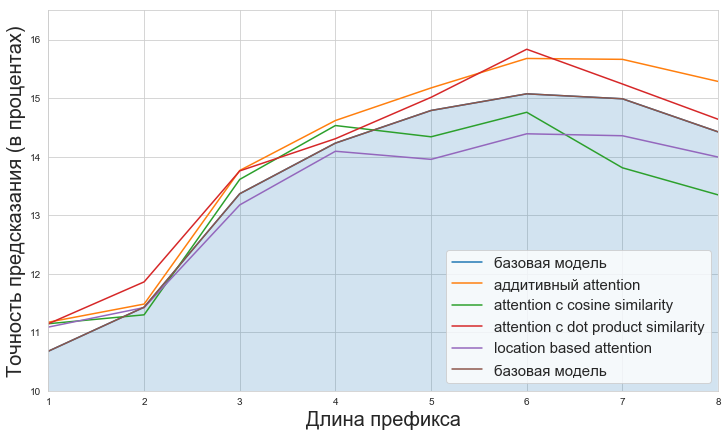

In [118]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 8) + 1
bound = len(grid)

additive = [0.14205298, 0.14598705, 0.17501215, 0.18585638, 0.19293589, \
            0.19933222, 0.19914347, 0.19434307, 0.14467409, 0.10951009]
cosine = [0.14172185, 0.14365306, 0.17306757, 0.18476632, 0.18231931, \
        0.18764608, 0.17558887, 0.16970803, 0.14626391, 0.09510086]
dotprod = [0.14172185, 0.1508056 , 0.17491492, 0.18190489, 0.19089424, \
        0.20133556, 0.19379015, 0.18613139, 0.12877583, 0.10086455]
locbased = [0.14099338, 0.14523415, 0.16752552, 0.17917972, 0.17741935, \
        0.18297162, 0.18254818, 0.17791971, 0.14626391, 0.08933718]

path = 'emb_2_lemmatization.txt'
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="базовая модель")
plt.plot(grid, 100*np.array(additive[:bound], dtype=float) * (1-test_pad[path]), 
         label="аддитивный attention")
plt.plot(grid, 100*np.array(cosine[:bound], dtype=float) * (1-test_pad[path]), 
         label="attention c cosine similarity")
plt.plot(grid, 100*np.array(dotprod[:bound], dtype=float) * (1-test_pad[path]), 
         label="attention c dot product similarity")
plt.plot(grid, 100*np.array(locbased[:bound], dtype=float) * (1-test_pad[path]), 
         label="location based attention")
path = 'emb_2_lemmatization.txt'
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="базовая модель")
plt.fill_between(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), alpha=0.2)

plt.xlabel("Длина префикса", fontsize=20)
plt.xlim([1, 8])
plt.ylim([10, 16.5])
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
#plt.title("Валидационный корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("attention.png")

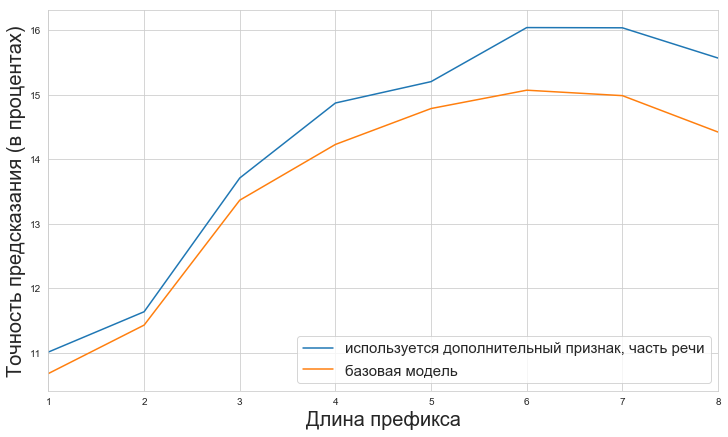

In [112]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 8) + 1
bound = len(grid)


plt.plot(grid, 100*np.array(on_test[:bound], dtype=float) * (1-test_pad[path]), 
         label="используется дополнительный признак, часть речи")
path = 'emb_2_lemmatization.txt'
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="базовая модель")

plt.xlabel("Длина префикса", fontsize=20)
plt.xlim([1, 8])
#plt.ylim([10, 15.5])
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
#plt.title("Валидационный корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("tag.png")

Оценка прироста качества при добавлении признака часть речи в биграммную модель

In [38]:
def bigramAnvanced(train, test):
    cnt = dict()
    for line in tqdm_notebook(train):
        prefix = ""
        for word in line:
            if prefix not in cnt and word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix] = Counter()
            if word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix][word] += 1
                prefix = word
            else:
                prefix = "#PAD#"
    
    max_len = np.max(list(map(len, test)))
    accrs = np.zeros((max_len, 2))
    
    for line in tqdm_notebook(test):
        prefix = ''
        for i, word in enumerate(line):
            if prefix in cnt:
                pred = cnt[prefix].most_common(1)[0][0]
                if pred == word:
                    accrs[i, 0] += 1
            accrs[i, 1] += 1   
            if word in count_words.keys() and count_words[word] >= 3:
                prefix = word 
            else:
                prefix = "#PAD#"
    return accrs[:, 0] / accrs[:, 1]

In [40]:
bigram = bigramAnvanced(train_lem[0], test_lem[0])
bigram[:10]

array([0.02914226, 0.10913886, 0.10295102, 0.12439879, 0.13151163,
       0.12804233, 0.14097043, 0.14259   , 0.12779553, 0.11875843])

In [43]:
def bigramAnvancedWithTag(train, test):
    cnt = dict()
    for i, line in tqdm_notebook(enumerate(train[0])):
        prefix = ""
        for j, word in enumerate(line):
            if prefix not in cnt and word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix] = Counter()
            if word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix][word] += 1
                prefix = word + train[1][i][j]
            else:
                prefix = "#PAD#" + train[1][i][j]

    
    max_len = np.max(list(map(len, test)))
    accrs = np.zeros((max_len, 2))
    
    for j, line in tqdm_notebook(enumerate(test[0])):
        prefix = ''
        for i, word in enumerate(line):
            if prefix in cnt:
                pred = cnt[prefix].most_common(1)[0][0]
                if pred == word:
                    accrs[i, 0] += 1
            accrs[i, 1] += 1   
            if word in count_words.keys() and count_words[word] >= 3:
                prefix = word + test[1][j][i]
            else:
                prefix = "#PAD#" + test[1][j][i]
    return accrs[:, 0] / accrs[:, 1]

In [44]:
bigram_tag = bigramAnvancedWithTag(train_lem, test_lem)
bigram_tag[:10]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


array([0.02914226, 0.11588396, 0.10623669, 0.12847477, 0.13697674,
       0.1313933 , 0.14412862, 0.14586255, 0.12939297, 0.12280702])

In [46]:
bigram[:10] * 100, bigram_tag[:10] * 100, (bigram_tag[:10] - bigram[:10]) * 100

(array([ 2.91422634, 10.91388579, 10.29510192, 12.43987935, 13.15116279,
        12.8042328 , 14.09704278, 14.25899953, 12.77955272, 11.87584345]),
 array([ 2.91422634, 11.58839639, 10.623669  , 12.84747697, 13.69767442,
        13.13932981, 14.41286247, 14.58625526, 12.93929712, 12.28070175]),
 array([0.        , 0.6745106 , 0.32856708, 0.40759762, 0.54651163,
        0.335097  , 0.3158197 , 0.32725573, 0.15974441, 0.4048583 ]))

In [64]:
tmp = (bigram_tag[:10] - bigram[:10]) * 100
tmp.mean(), tmp.std(), tmp.max()

(0.34999620623795347, 0.1764412429495211, 0.6745105994522771)

In [67]:
import pandas as pd

bound = 7
df = {'простая биграммная модель': bigram[:bound] * 100, 'модель с использованием частей речи': bigram_tag[:bound] * 100, \
     'прирост качества': bigram_tag[:bound] * 100 - bigram[:bound] * 100}
df = pd.DataFrame(df)
df.T

,0,1,2,3,4,5,6
простая биграммная модель,2.914226,10.913886,10.295102,12.439879,13.151163,12.804233,14.097043
модель с использованием частей речи,2.914226,11.588396,10.623669,12.847477,13.697674,13.139330,14.412862
прирост качества,0.000000,0.674511,0.328567,0.407598,0.546512,0.335097,0.315820


* попробуем учить предсказание следующего тега

In [68]:
class NetWithTags(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens) 
        self.logits_tags = nn.Linear(lstm_units, len(tags))
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)
        logits = self.logits(lstm_out[0])
        logits_tags = self.logits_tags(lstm_out[0])
        return logits, logits_tags

In [18]:
def compute_loss(network, batch):
    """
    use scalar crossentropy loss (neg llh) loss 
    """
    batch_x = batch[0]
    batch_tags = batch[1]
    batch_x = np.array(batch_x)
    batch_tags = np.array(batch_tags)

    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    batch_tags_inp = batch_tags[:, :-1]
    batch_tags_next = batch_tags[:, 1:]
    
    logits_for_next, logits_tags_for_next = network.forward(batch_x_inp, batch_tags_inp)
    logits_for_next = logits_for_next[:, 1:]
    logits_tags_for_next = logits_tags_for_next[:, 1:]
    
    answers = torch.argmax(logits_for_next, dim=-1).numpy()
    tags = torch.argmax(logits_tags_for_next, dim=-1).numpy()
    logits_for_next = logits_for_next.contiguous()
    logits_for_next = logits_for_next.view(-1, logits_for_next.shape[-1])
    logits_tags_for_next = logits_tags_for_next.contiguous()
    logits_tags_for_next = logits_tags_for_next.view(-1, logits_tags_for_next.shape[-1])
    
    accr = np.array([answers == batch_x_next]) * np.array([answers != pad_id])
    accr = accr.sum()
    accr_tags = np.array([tags == batch_tags_next]) * np.array([batch_x_next != pad_id])
    accr_tags = accr_tags.sum()
    to_div = np.sum(np.array([batch_x_next != pad_id]))
    
    batch_x_next = torch.tensor(batch_x_next, dtype=torch.int64)
    batch_x_next = batch_x_next.view(-1)
    batch_tags_next = torch.tensor(batch_tags_next, dtype=torch.int64)
    batch_tags_next = batch_tags_next.view(-1)
    
    loss = F.cross_entropy(logits_for_next, batch_x_next, ignore_index=pad_id, reduction='mean')
    loss += F.cross_entropy(logits_tags_for_next, batch_tags_next, ignore_index=-1, reduction='mean')
    
    return loss, accr, accr_tags, to_div

In [19]:
from torch.optim import Adam
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = NetWithTags(emb_2, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr, train_tags_accr, val_tags_accr = [], [], [], [], [], []

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    train_accr_tags_=0
    to_div = 0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t, accr_tags_t, to_div_t = compute_loss(network, generate_batch(train_lem, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        train_accr_tags_ += accr_tags_t.item()
        to_div += to_div_t
        
    train_loss_ /= n_batches_per_epoch
    #train_accr_ /= n_batches_per_epoch
    train_accr_ /= to_div
    train_accr_tags_ /= to_div
    
    val_loss_=0
    val_accr_=0
    val_accr_tags_=0
    to_div = 0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t, accr_tags_t, to_div_t = compute_loss(network, generate_batch(test_lem, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
        val_accr_tags_ += accr_tags_t.item()
        to_div += to_div_t
        
    val_loss_ /= n_validation_batches
    #val_accr_ /= n_validation_batches
    val_accr_ /= to_div
    val_accr_tags_ /= to_div
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    train_tags_accr.append(train_accr_tags_)
    val_tags_accr.append(val_accr_tags_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))
    print('\nEpoch: {}, train accr tags: {}, val accr tags: {}'.format(epoch, train_accr_tags_, val_accr_tags_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 8.267957304716111, val loss: 7.728692108392716

Epoch: 0, train accr: 0.05421031152224187, val accr: 0.07534610345926425

Epoch: 0, train accr tags: 0.3698000272071827, val accr tags: 0.4069680982898417


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 7.374649313688278, val loss: 7.271440061926842

Epoch: 1, train accr: 0.10069555484489927, val accr: 0.09989834904833678

Epoch: 1, train accr tags: 0.43771985929005436, val accr tags: 0.43352378281748394


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.878707815408706, val loss: 7.069121909141541

Epoch: 2, train accr: 0.12169775717058443, val accr: 0.11507711900382057

Epoch: 2, train accr tags: 0.4559790813025663, val accr tags: 0.45670015565303523


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 6.527763129472732, val loss: 6.842003047466278

Epoch: 3, train accr: 0.13974178874841126, val accr: 0.12707162921348314

Epoch: 3, train accr tags: 0.4575824469864205, val accr tags: 0.44476825842696627


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 6.257463295459747, val loss: 6.79649071097374

Epoch: 4, train accr: 0.15493754038337282, val accr: 0.13386904344164502

Epoch: 4, train accr tags: 0.46859519707085934, val accr tags: 0.4391185346340094


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 6.005881768465042, val loss: 6.6623375654220585

Epoch: 5, train accr: 0.16684726661971067, val accr: 0.14521770164168452

Epoch: 5, train accr tags: 0.47251720214552745, val accr tags: 0.4359386152748037


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 5.798693032264709, val loss: 6.66399749815464

Epoch: 6, train accr: 0.18230402181322428, val accr: 0.14916307648845256

Epoch: 6, train accr tags: 0.47426039536468984, val accr tags: 0.44416978600183626


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 5.588264954090119, val loss: 6.62012488245964

Epoch: 7, train accr: 0.1962257090160648, val accr: 0.14937150837988827

Epoch: 7, train accr tags: 0.47885648606024966, val accr tags: 0.4510474860335196


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 5.41773368358612, val loss: 6.633986100554466

Epoch: 8, train accr: 0.21007303014349546, val accr: 0.14975620249533916

Epoch: 8, train accr tags: 0.4800280781328042, val accr tags: 0.46522300301161623


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 5.211251986026764, val loss: 6.579390147328377

Epoch: 9, train accr: 0.22919975236198217, val accr: 0.1606601901180403

Epoch: 9, train accr tags: 0.4898253075287341, val accr tags: 0.4685051707928549


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 5.050846446752548, val loss: 6.661893221735954

Epoch: 10, train accr: 0.2410517160634241, val accr: 0.15630931458699474

Epoch: 10, train accr tags: 0.4902923663611427, val accr tags: 0.45669595782073813


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.901814500689507, val loss: 6.61885007917881

Epoch: 11, train accr: 0.2562428749796428, val accr: 0.1640438386960798

Epoch: 11, train accr tags: 0.4925492644264698, val accr tags: 0.45001405086412816


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.727243905067444, val loss: 6.598089098930359

Epoch: 12, train accr: 0.27415812098263015, val accr: 0.1654510556621881

Epoch: 12, train accr tags: 0.4962605613874328, val accr tags: 0.4618740184958995


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 4.613934078216553, val loss: 6.704738259315491

Epoch: 13, train accr: 0.2911463712327481, val accr: 0.15886569681636095

Epoch: 13, train accr tags: 0.4976326837184973, val accr tags: 0.4627521259399817


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.453952410817147, val loss: 6.644101104140281

Epoch: 14, train accr: 0.3092866756393001, val accr: 0.16365486508298538

Epoch: 14, train accr tags: 0.50185733512786, val accr tags: 0.4715604056282677


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 4.355333862304687, val loss: 6.73932549059391

Epoch: 15, train accr: 0.31899863842866577, val accr: 0.1647569991940853

Epoch: 15, train accr tags: 0.50301298211084, val accr tags: 0.45022600651739725


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 4.234209511876106, val loss: 6.710313439369202

Epoch: 16, train accr: 0.33668321588725175, val accr: 0.16350416740556836

Epoch: 16, train accr tags: 0.5064995729233397, val accr tags: 0.4584855470828161


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 4.119367979168892, val loss: 6.804924938082695

Epoch: 17, train accr: 0.34934791981030394, val accr: 0.16087094387485468

Epoch: 17, train accr tags: 0.5083800388014659, val accr tags: 0.44833174787725044


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 4.033529533743859, val loss: 6.821166551113128

Epoch: 18, train accr: 0.365685019206146, val accr: 0.16335493160547157

Epoch: 18, train accr tags: 0.5113282566210661, val accr tags: 0.4712023038156947


100%|██████████| 400/400 [02:55<00:00,  2.72it/s]



Epoch: 19, train loss: 3.9156561106443406, val loss: 6.831090602278709

Epoch: 19, train accr: 0.380852176010937, val accr: 0.16100197851893724

Epoch: 19, train accr tags: 0.5127263466873969, val accr tags: 0.4583451102317694
Finished!


In [20]:
torch.save(network.state_dict(), 'add_pos_tagging_as_feature_and_in_loss.pwf')

In [69]:
ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = NetWithTags(emb_2, ind_to_word)
network.load_state_dict(torch.load('add_pos_tagging_as_feature_and_in_loss.pwf'))

In [70]:
def compute_accr(network, batch):
    batch_x = batch[0]
    batch_tag = batch[1]
    
    batch_x = np.array(batch_x)
    batch_tag = np.array(batch_tag)
    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    batch_tag_inp = batch_tag[:, :-1]
    batch_tag_next = batch_tag[:, 1:]
    
    logits_for_next, logits_tags_for_next = network.forward(batch_x_inp, batch_tag_inp)
    logits_for_next = logits_for_next[:, 1:]
    logits_tags_for_next = logits_tags_for_next[:, 1:]
    
    answers = torch.argmax(logits_for_next, dim=-1).numpy()
    tags = torch.argmax(logits_tags_for_next, dim=-1).numpy()
    
    accr = np.array([answers == batch_x_next]) * np.array([answers != pad_id])
    accr = accr[0]
    accr = accr.sum(axis=0)
    accr_tags = np.array([tags == batch_tag_next]) * np.array([batch_x_next != pad_id])
    accr_tags = accr_tags[0]
    accr_tags = accr_tags.sum(axis=0)
    to_divide = np.array([batch_x_next != pad_id])[0].sum(axis=0)
    
    return accr, accr_tags, to_divide

def get_batch(data, left, right, batch_size, word_to_ind, max_len=None):
    slice_x = np.arange(left, right, 1)
    batch_x = []
    batch_tag = []
    for x in slice_x:
        batch_x.append(data[0][x])
        batch_tag.append(data[1][x])
    return as_matrix(batch_x, batch_tag, word_to_ind, max_len)

def try_lengthes(data):
    accr = np.zeros(np.max(list(map(len, data[0]))))
    accr_tags = np.zeros(np.max(list(map(len, data[0]))))
    to_div = np.zeros(np.max(list(map(len, data[0]))))
    
    for _ in tqdm_notebook(range(0, len(data[0])-batch_size, batch_size)):
        accr_t, accr_tags_t, div_t = compute_accr(network, get_batch(data, _, _+batch_size, batch_size, word_to_ind))
        accr[:len(accr_t)] += accr_t
        to_div[:len(div_t)] += div_t
        accr_tags[:len(accr_tags_t)] += accr_tags_t
    eps = 1
    return accr / (to_div + eps), accr_tags / (to_div + eps), accr.sum() / to_div.sum(), accr_tags.sum() / to_div.sum()

In [25]:
from tqdm import tqdm_notebook

on_train, on_train_tags, all_accr, all_accr_tags = try_lengthes(train_lem)
on_train[:10], on_train_tags[:10], all_accr, all_accr_tags

(array([0.219969  , 0.32748882, 0.45278524, 0.49261267, 0.53258372,
        0.52887052, 0.55344365, 0.54452055, 0.53320184, 0.49361208]),
 array([0.60958409, 0.51012003, 0.48772832, 0.4594494 , 0.42769206,
        0.40512068, 0.40317531, 0.40905632, 0.40368179, 0.40998839]),
 0.384947422209074,
 0.5055805072210419)

In [71]:
on_test, on_test_tags, all_accr, all_accr_tags = try_lengthes(test_lem)
on_test[:10], on_test_tags[:10], all_accr, all_accr_tags

(array([0.14      , 0.14794459, 0.17433155, 0.18912658, 0.19334422,
        0.20400668, 0.20396146, 0.1979927 , 0.16216216, 0.11239193]),
 array([0.58516556, 0.45859057, 0.41915411, 0.39801063, 0.36504696,
        0.35358932, 0.32601713, 0.34032847, 0.3608903 , 0.32564841]),
 0.16418140155272068,
 0.45334997776941754)

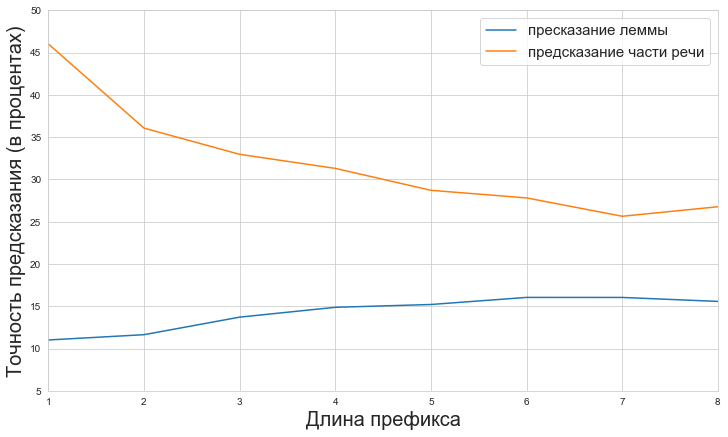

In [74]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 8) + 1
bound = len(grid)


plt.plot(grid, 100*np.array(on_test[:bound], dtype=float) * (1-test_pad[path]), 
         label="пресказание леммы")
path = 'emb_2_lemmatization.txt'
plt.plot(grid, 100*np.array(on_test_tags[:bound], dtype=float) * (1-test_pad[path]), 
         label="предсказание части речи")

plt.xlabel("Длина префикса", fontsize=20)
plt.xlim([1, 8])
plt.ylim([5, 50])
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
#plt.title("Валидационный корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("lem_and_tag.png")

In [26]:
on_test, on_test_tags, all_accr, all_accr_tags = try_lengthes(test_lem)
on_test[:10], on_test_tags[:10], all_accr, all_accr_tags

(array([0.14      , 0.14794459, 0.17433155, 0.18912658, 0.19334422,
        0.20400668, 0.20396146, 0.1979927 , 0.16216216, 0.11239193]),
 array([0.58516556, 0.45859057, 0.41915411, 0.39801063, 0.36504696,
        0.35358932, 0.32601713, 0.34032847, 0.3608903 , 0.32564841]),
 0.16418140155272068,
 0.45334997776941754)

Посмотрим на распределение категориального признака часть речи

In [104]:
def calculate_dist(data, i):
    nums = dict()
    count = 0
    for t in tags:
        nums[t] = count
        count += 1
    stat = np.zeros(len(tags))
    
    for sent in data:
        if len(sent) >= i+1:
            tag = sent[i]
            stat[nums[tag]] += 1
    stat = np.array(stat)
    return stat / stat.sum(), nums

(53, 'S')

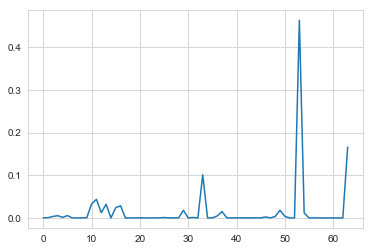

In [109]:
dist, nums = calculate_dist(test_lem[1], 0)
plt.plot(np.arange(0, len(dist)), dist)
for tag in nums.keys():
    if nums[tag] == dist.argmax():
        tag_ = tag
dist.argmax(), tag_

(53, 'S')

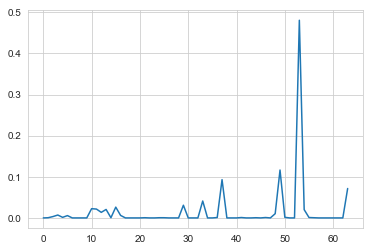

In [110]:
dist, nums = calculate_dist(test_lem[1], 7)
plt.plot(np.arange(0, len(dist)), dist)
for tag in nums.keys():
    if nums[tag] == dist.argmax():
        tag_ = tag
dist.argmax(), tag_

* посмотрим насколько знание тэга может улучшить биграммное предсказание

In [28]:
cnt = dict()
for i, line in tqdm_notebook(enumerate(train_lem[0])):
    prefix = ""
    for j, word in enumerate(line):
        if prefix not in cnt.keys():
            cnt[prefix] = Counter()
        cnt[prefix][word] += 1
        prefix = word

accr = np.zeros(np.max(list(map(len, test_lem[0]))))
to_div = np.zeros_like(accr)
for i, line in tqdm_notebook(enumerate(test_lem[0])):
    prefix = ""
    for j, word in enumerate(line):
        to_div[j] += 1
        if prefix in cnt.keys() and cnt[prefix].most_common(1)[0][0] == word:
            accr[j] += 1
        prefix = word

In [29]:
accr / to_div * 100

array([ 2.91422634, 11.6593975 , 10.16124125, 12.48063911, 12.96511628,
       12.91005291, 14.01091013, 14.58625526, 12.5399361 , 12.82051282,
        8.27250608,  7.239819  ,  6.81818182,  4.87804878,  3.33333333,
        0.        ,  3.03030303,  3.44827586,  4.34782609,  5.55555556,
        6.66666667,  7.14285714,  7.69230769,  0.        ,  8.33333333,
        0.        ,  0.        ,  0.        ,  0.        , 12.5       ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 25.        ,  0.        ,  0.        ,
        0.        ,  0.        , 33.33333333,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [34]:
cnt = dict()
for i, line in tqdm_notebook(enumerate(train_lem[0])):
    prefix = ""
    prefix_tag = ""
    for j, word in enumerate(line):
        if prefix not in cnt.keys():
            cnt[prefix] = dict()
        if prefix_tag not in cnt[prefix].keys():
            cnt[prefix][prefix_tag] = Counter()
        cnt[prefix][prefix_tag][word] += 1
        prefix = word
        prefix_tag = train_lem[1][i][j]

accr = np.zeros(np.max(list(map(len, test_lem[0]))))
to_div = np.zeros_like(accr)
for i, line in tqdm_notebook(enumerate(test_lem[0])):
    prefix = ""
    prefix_tag = ""
    for j, word in enumerate(line):
        to_div[j] += 1
        if prefix in cnt.keys() and prefix_tag in cnt[prefix].keys() and cnt[prefix][prefix_tag].most_common(1)[0][0] == word:
            accr[j] += 1
        prefix = word
        prefix_tag = test_lem[1][i][j]

In [35]:
accr / to_div * 100

array([ 2.91422634, 12.13611928, 10.31335564, 12.71704573, 13.46511628,
       13.22751323, 14.38415159, 14.53950444, 12.69968051, 13.09041835,
        8.27250608,  7.69230769,  6.81818182,  3.65853659,  3.33333333,
        0.        ,  3.03030303,  3.44827586,  4.34782609,  5.55555556,
        6.66666667,  7.14285714,  7.69230769,  0.        ,  8.33333333,
        0.        ,  0.        ,  0.        ,  0.        , 25.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 50.        ,  0.        ,  0.        ,
        0.        ,  0.        , 33.33333333,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

* попробуем учить промежуточное представление тег

In [75]:
class NetWithInnerTags(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.logits_tags = nn.Linear(lstm_units, len(tags))
        self.logits = nn.Linear(lstm_units + len(tags), n_tokens) 
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)
        logits_tags = self.logits_tags(lstm_out[0])
        #print(lstm_out[0].shape)
        #print(logits_tags.shape)
        inner = torch.cat([lstm_out[0], logits_tags], dim=2)
        #print(inner.shape)
        logits = self.logits(inner)
        return logits, logits_tags

In [76]:
from torch.optim import Adam
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = NetWithInnerTags(emb_2, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr, train_tags_accr, val_tags_accr = [], [], [], [], [], []

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    train_accr_tags_=0
    to_div = 0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t, accr_tags_t, to_div_t = compute_loss(network, generate_batch(train_lem, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        train_accr_tags_ += accr_tags_t.item()
        to_div += to_div_t
        
    train_loss_ /= n_batches_per_epoch
    #train_accr_ /= n_batches_per_epoch
    train_accr_ /= to_div
    train_accr_tags_ /= to_div
    
    val_loss_=0
    val_accr_=0
    val_accr_tags_=0
    to_div = 0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t, accr_tags_t, to_div_t = compute_loss(network, generate_batch(test_lem, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
        val_accr_tags_ += accr_tags_t.item()
        to_div += to_div_t
        
    val_loss_ /= n_validation_batches
    #val_accr_ /= n_validation_batches
    val_accr_ /= to_div
    val_accr_tags_ /= to_div
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    train_tags_accr.append(train_accr_tags_)
    val_tags_accr.append(val_accr_tags_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))
    print('\nEpoch: {}, train accr tags: {}, val accr tags: {}'.format(epoch, train_accr_tags_, val_accr_tags_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 8.303791218996048, val loss: 7.757710286974907

Epoch: 0, train accr: 0.05601673662612147, val accr: 0.07817403708987161

Epoch: 0, train accr tags: 0.36281464991215956, val accr tags: 0.4117689015691869


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 7.297870186567306, val loss: 7.279327535629273

Epoch: 1, train accr: 0.10737599240008143, val accr: 0.10968498897816967

Epoch: 1, train accr tags: 0.44399810002035695, val accr tags: 0.43809997866742517


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.776656460762024, val loss: 7.008813089132309

Epoch: 2, train accr: 0.1310105840004298, val accr: 0.12266134118141686

Epoch: 2, train accr tags: 0.4608472572932896, val accr tags: 0.4344124448181627


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 6.451160465478897, val loss: 6.857466557621956

Epoch: 3, train accr: 0.14897292628282993, val accr: 0.13246927532137306

Epoch: 3, train accr tags: 0.464733986557616, val accr tags: 0.45197061731883037


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 6.15686475276947, val loss: 6.807031381130218

Epoch: 4, train accr: 0.164189225844952, val accr: 0.1385187263290784

Epoch: 4, train accr tags: 0.47159984809851896, val accr tags: 0.43754383503997757


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.875315719842911, val loss: 6.746081846952438

Epoch: 5, train accr: 0.1795619065525994, val accr: 0.14516241461034435

Epoch: 5, train accr tags: 0.4771350676211069, val accr tags: 0.4516589990241182


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 5.629111404418945, val loss: 6.798665112257003

Epoch: 6, train accr: 0.1997396998413796, val accr: 0.1504864711313117

Epoch: 6, train accr tags: 0.48249074714279905, val accr tags: 0.45160144876074143


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 5.424141116142273, val loss: 6.70615745484829

Epoch: 7, train accr: 0.21504924170487533, val accr: 0.1550010499055085

Epoch: 7, train accr tags: 0.4830570552646572, val accr tags: 0.46052355288024077


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 5.191770613193512, val loss: 6.7624166160821915

Epoch: 8, train accr: 0.23734861591695502, val accr: 0.15754123149418012

Epoch: 8, train accr tags: 0.4867133434256055, val accr tags: 0.43984949185919753


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 5.021691401004791, val loss: 6.796793347597122

Epoch: 9, train accr: 0.2539049384208335, val accr: 0.15474292193756423

Epoch: 9, train accr tags: 0.4916260391904052, val accr tags: 0.4625987739626519


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.843171019554138, val loss: 6.7978469043970104

Epoch: 10, train accr: 0.2731442869057548, val accr: 0.15801267462623858

Epoch: 10, train accr tags: 0.4922247033818505, val accr tags: 0.46185357655544274


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.681850023269654, val loss: 6.847008913755417

Epoch: 11, train accr: 0.2887386538098958, val accr: 0.15620182200420463

Epoch: 11, train accr tags: 0.49781829935087674, val accr tags: 0.45749824807288014


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.507625972032547, val loss: 6.858459803462028

Epoch: 12, train accr: 0.31058614133732454, val accr: 0.15811226111837226

Epoch: 12, train accr tags: 0.5003303534107304, val accr tags: 0.47497262354728176


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 4.37376730620861, val loss: 6.971800044178963

Epoch: 13, train accr: 0.32655122266508674, val accr: 0.15913213587053174

Epoch: 13, train accr tags: 0.5030297317677475, val accr tags: 0.4683620842966388


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.2266193014383315, val loss: 6.9484130322933195

Epoch: 14, train accr: 0.3444690803882865, val accr: 0.15395299145299146

Epoch: 14, train accr tags: 0.5085174269258849, val accr tags: 0.44985754985754983


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 4.115387309193611, val loss: 7.036811563372612

Epoch: 15, train accr: 0.361919168931311, val accr: 0.16159775753328662

Epoch: 15, train accr tags: 0.5126173041138435, val accr tags: 0.4536790469516468


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.9755023175477984, val loss: 7.075371396541596

Epoch: 16, train accr: 0.3782862641842313, val accr: 0.15427919903085585

Epoch: 16, train accr tags: 0.5138267017736137, val accr tags: 0.4617686880923537


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.865159631371498, val loss: 7.12977782189846

Epoch: 17, train accr: 0.39209714154795755, val accr: 0.15765955949616495

Epoch: 17, train accr tags: 0.5127963234996833, val accr tags: 0.4556681443951868


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.735274168848991, val loss: 7.143848976492881

Epoch: 18, train accr: 0.40771895101434935, val accr: 0.16508168739331872

Epoch: 18, train accr tags: 0.5195715260039852, val accr tags: 0.46459051799212736


100%|██████████| 400/400 [03:30<00:00,  1.12it/s]



Epoch: 19, train loss: 3.6728498983383178, val loss: 7.258537444472313

Epoch: 19, train accr: 0.42210088893072795, val accr: 0.15643330672312658

Epoch: 19, train accr tags: 0.523487405693998, val accr tags: 0.463989448474541
Finished!


In [77]:
torch.save(network.state_dict(), 'add_pos_tagging_inner_layer.pwf')

In [78]:
on_train, on_train_tags, all_accr, all_accr_tags = try_lengthes(train_lem)
on_train[:10], on_train_tags[:10], all_accr, all_accr_tags

(array([0.22645311, 0.3594081 , 0.50398971, 0.55208333, 0.59709455,
        0.60381384, 0.62298748, 0.62519026, 0.60157791, 0.6155633 ]),
 array([0.61431155, 0.53768534, 0.51703664, 0.49819303, 0.4562541 ,
        0.43232431, 0.42620751, 0.42656012, 0.41485865, 0.42508711]),
 0.4249589866336767,
 0.528104241185488)

In [79]:
on_test, on_test_tags, all_accr, all_accr_tags = try_lengthes(test_lem)
on_test[:10], on_test_tags[:10], all_accr, all_accr_tags

(array([0.13437086, 0.14207198, 0.1718036 , 0.18258618, 0.18599428,
        0.20033389, 0.17665953, 0.17244526, 0.14785374, 0.09221902]),
 array([0.58384106, 0.48004819, 0.4305299 , 0.41122769, 0.38321764,
        0.36093489, 0.32762313, 0.35766423, 0.34022258, 0.32276657]),
 0.15766613085262834,
 0.46352474434830193)